## **Eye Diseases Classification 👁️**

The [dataset](https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification) consists of Normal, Diabetic Retinopathy, Cataract, and Glaucoma retinal images, where each class has approximately 1000 images. These images are collected from various sources like IDRiD, Oculur recognition, HRF, etc.



In [ ]:
# Connecting Google drive to Google colab environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
# Change working directory to folder created previously
%cd '/content/drive/My Drive/eye_diseases'

/content/drive/My Drive/eye_diseases


## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torchmetrics import Accuracy, ConfusionMatrix, Precision, Recall, F1Score

from tqdm import tqdm

## Load Data

In [ ]:
def load_data():
    # Define the transformation for loading and resizing images
    t = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((256, 256)),
        ]
    )
     # Load images using ImageFolder dataset
    return datasets.ImageFolder(root="/content/drive/My Drive/eye_diseases", transform=t)

In [ ]:
dataset = load_data()

In [ ]:
# Display dataset information
# Number of datapoints, Root location, and applied transforms
# This provides a quick overview of the dataset structure.
dataset

Dataset ImageFolder
    Number of datapoints: 4267
    Root location: /content/drive/My Drive/eye_diseases
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
           )

In [ ]:
# number of classes
NUMBER_OF_CLASSES = len(set(dataset.targets))
print(f"Number of classes: {NUMBER_OF_CLASSES}")

Number of classes: 4


## Exploring Images

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Label : cataract


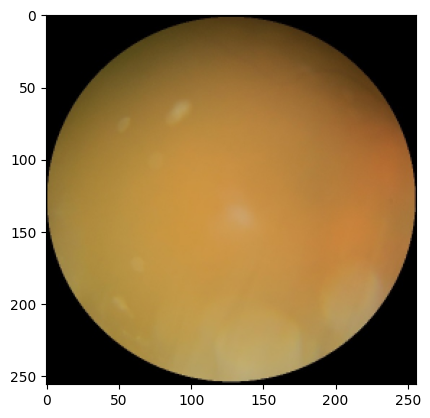

In [ ]:
def display_image(image, label):
  # Display the label of the image using the class names
    print(f"Label : {dataset.classes[label]}")
    # Display the image using matplotlib
    plt.imshow(image.permute(1, 2, 0))


# display an image in the dataset
display_image(*dataset[99])

## Split Data Into Train-Test

In [ ]:
def train_test_split(dataset, train_size, random_state=42):
  # Split the dataset into training and testing sets
    train_size = int(train_size * len(dataset))
    test_size = len(dataset) - train_size
    seed = torch.Generator().manual_seed(random_state)
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size], generator=seed
    )

    return train_dataset, test_dataset

In [ ]:
# Perform a train-test split with 80% for training
train_dataset, test_dataset = train_test_split(dataset, 0.8)

## DataLoader

In [ ]:
# Create DataLoader instances for training and testing sets
batch_size = 32
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Visualizing the Batch Images

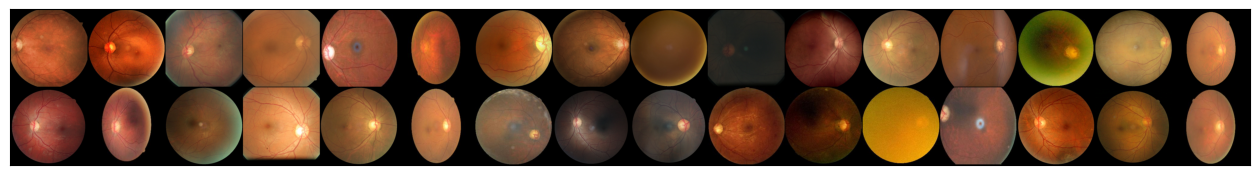

In [ ]:
def show_batch(data_loader):
    """Plot images grid of single batch"""
    # Visualize a batch of images
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

# Show a batch of training images
show_batch(train_dataloader)

## Convolutional Neural Network (CNN)

In [ ]:
class CNN(nn.Module):
    def __init__(self, NUMBER_OF_CLASSES):
        super(CNN, self).__init__()
        # Define the layers of the convolutional neural network
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Define the dense layers of the network
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, NUMBER_OF_CLASSES),
        )

    def forward(self, x):
      # Forward pass through convolutional and dense layers
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.dense_layers(x)

        return x

In [ ]:
# Create an instance of the CNN model
model = CNN(NUMBER_OF_CLASSES)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## Device Configuration

In [ ]:
# Device configuration
# Use GPU if available, otherwise use CPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    device = "mps"

### **TRAINING FUNCTION**

In [ ]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  # Move the model to the specified device
    model.to(device)
    # Arrays to store training and testing losses
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    # Accuracy metric
    accuracy = Accuracy(task="multiclass",
                        num_classes=NUMBER_OF_CLASSES).to(device)

    # Training loop
    for epoch in range(epochs):
        train_loss = []
        # Iterate over training data
        for inputs, targets in tqdm(train_loader, desc=f'Training... Epoch: {epoch + 1}/{epochs}'):
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get average training loss for the epoch
        train_loss = np.mean(train_loss)
        # Calculate training accuracy
        train_accuracy = accuracy(outputs, targets)

        # Validation loop
        test_loss = []
        for inputs, targets in tqdm(test_loader, desc=f'Validating... Epoch: {epoch + 1}/{epochs}'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss.append(loss.item())

        # Get average testing loss for the epoch
        test_loss = np.mean(test_loss)
        # Calculate testing accuracy
        test_accuracy = accuracy(outputs, targets)

        # Save losses
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss

        # Print epoch-wise results
        print(f"Epoch {epoch+1}/{epochs}:")
        print(
            f"Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}")
        print(
            f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")
        print('-'*30)

    return train_losses, test_losses

In [ ]:
# Train the model for 7 epochs
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_dataloader, test_dataloader, epochs=7
)

Validating... Epoch: 1/7: 100%|██████████| 27/27 [01:44<00:00,  3.88s/it]


Epoch 1/7:
Train Loss: 0.72, Train Accuracy: 0.76
Test Loss: 0.61, Test Accuracy: 0.73
------------------------------


Validating... Epoch: 2/7: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 2/7:
Train Loss: 0.57, Train Accuracy: 0.71
Test Loss: 0.56, Test Accuracy: 0.77
------------------------------


Validating... Epoch: 3/7: 100%|██████████| 27/27 [00:33<00:00,  1.23s/it]


Epoch 3/7:
Train Loss: 0.50, Train Accuracy: 0.81
Test Loss: 0.51, Test Accuracy: 0.73
------------------------------


Validating... Epoch: 4/7: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch 4/7:
Train Loss: 0.44, Train Accuracy: 0.86
Test Loss: 0.50, Test Accuracy: 0.82
------------------------------


Validating... Epoch: 5/7: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


Epoch 5/7:
Train Loss: 0.42, Train Accuracy: 0.86
Test Loss: 0.45, Test Accuracy: 0.73
------------------------------


Validating... Epoch: 6/7: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]


Epoch 6/7:
Train Loss: 0.39, Train Accuracy: 0.90
Test Loss: 0.48, Test Accuracy: 0.82
------------------------------


Validating... Epoch: 7/7: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]

Epoch 7/7:
Train Loss: 0.36, Train Accuracy: 0.90
Test Loss: 0.46, Test Accuracy: 0.82
------------------------------


## Plotting the Losses

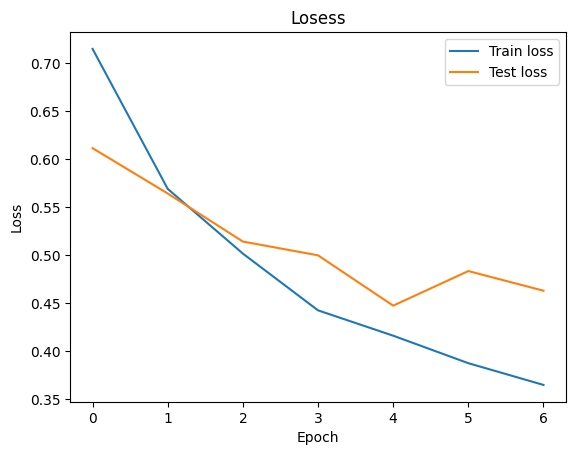

In [ ]:
# Plot the training and testing losses
plt.title("Losess")
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Prediction

In [ ]:
# Lists to store true and predicted labels
y_pred_list = []
y_true_list = []

# Perform prediction on the test dataset
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predections = torch.max(outputs, 1)

        y_pred_list.append(targets.cpu().numpy())
        y_true_list.append(predections.cpu().numpy())

# Flatten the lists into tensors for evaluation
targets = torch.tensor(np.concatenate(y_true_list))
preds = torch.tensor(np.concatenate(y_pred_list))

### **EVALUATION OF MODEL PERFORMANCE**

### Confusion Matrix

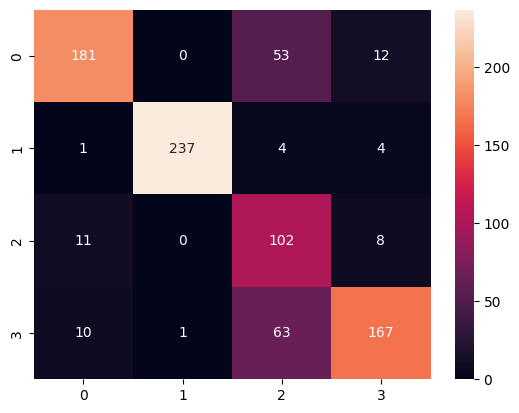

In [ ]:
confmat = ConfusionMatrix(task="multiclass", num_classes=NUMBER_OF_CLASSES)
cm = confmat(preds, targets)
# Display the confusion matrix as a heatmap
sn.heatmap(cm, annot=True, fmt=".0f")
plt.show()

### Accuracy

In [ ]:
# Calculate and print the overall accuracy
accuracy = Accuracy(task="multiclass", num_classes=NUMBER_OF_CLASSES).to(device)
accuracy = accuracy(preds, targets)
print(f"Accuracy: {100 * accuracy:.2f}%")

Accuracy: 80.44%


### Precision

In [ ]:
# Calculate and print the precision
precision = Precision(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
precision = precision(preds, targets)
print(f"Precision: {100 * precision:.2f}%")

Precision: 80.44%


### Recall

In [ ]:
# Calculate and print the recall
recall = Recall(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
recall = recall(preds, targets)
print(f"Recall: {100 * recall:.2f}%")

Recall: 80.44%


### F1-Score

In [ ]:
# Calculate and print the F1 score
f1 = F1Score(task="multiclass", num_classes=NUMBER_OF_CLASSES)
f1 = f1(preds, targets)
print(f"F1 Score: {100 * f1:.2f}%")

F1 Score: 80.44%


### Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Flatten the true and predicted labels
flat_true_labels = targets.cpu().numpy()
flat_pred_labels = preds.cpu().numpy()

# Classification Report
classification_rep = classification_report(flat_true_labels, flat_pred_labels, target_names=dataset.classes)
print("Classification Report:\n", classification_rep)

Classification Report:
                       precision    recall  f1-score   support

            cataract       0.89      0.74      0.81       246
diabetic_retinopathy       1.00      0.96      0.98       246
            glaucoma       0.46      0.84      0.59       121
              normal       0.87      0.69      0.77       241

            accuracy                           0.80       854
           macro avg       0.81      0.81      0.79       854
        weighted avg       0.86      0.80      0.82       854

